# Active learning and deep probabalistic ensembles

[Active learning](http://www.cs.northwestern.edu/~pardo/courses/mmml/papers/active_learning/improving_generalization_with_active_learning_ML94.pdf), loosely described, is an iterative process for getting the most out of your training data. This is especially useful for cases where you have a lot of unlabeled data that you would like to use for [supervised training](https://en.wikipedia.org/wiki/Supervised_learning). Since labeling data can be extremely time consuming and costly, you want to choose which data points to label strategically so that you total training set consists of a rich and diverse set of examples that minimize redundancy and maximize generalization.

Last week at PyData Miami, Clément Farabet of NVIDIA discussed some of their researchers' work where they introduce a method for training a "[deep probabalistic ensemble](https://arxiv.org/pdf/1811.03575.pdf)" and apply the ensemble to active learning.

## Motivation

Why "deep probabalistic ensembles"? To answer this question, let's take a step back. and consider a common pattern for active learning. Let's suppose we have two data sets at hand, $D_{L}=\{X_{L}, y_{L}\}$ and $D_{U}=\{X_{U}\}$, where the first data set is labeled and the second is not. Additionally suppose we have a model $f: X\rightarrow y$ and a function $u: f(x)\rightarrow \mathbb{R}$ that measures the uncertainty of a given prediction $f(x)$. We can train $f$ on $D_{L}$ and exploit the uncertainty of the predictions $\{f(x); x\in X_{U}\}$ to determine which data points in $X_{U}$ should be labeled next. For example, a sketch of this algorithm looks like

1. Train $f$ on $D_{L}$.
2. Obtain the predictions $\{f(x); x\in X_{U}\}$.
3. Use $u$ to calculate the uncertainty of each prediction.
4. Select the top $n$ data points in $X_{U}$ where the model's predictions are most uncertain.

After labeling these points we can update $D_{L}$ and repeat the process as desired.

Of course, since we've mentioned the word "uncertainty" several times by now it should be clear why we are interested in deep probabalistic networks. Theoretically we can define a deep neural network 

$$
\begin{equation}
P(w \ \vert \ x)=\frac{P(w)P(w\ \vert \ x)}{P(x)}
\label{eq:posterior}
\end{equation}
$$

where $w$ is the set of all weights in the network for which we define the prior $P(w)$. From such a model we could obtain not only predictions of our target variable $y$ but also a measure of uncertainty for those predictions.

However, it is well known that training a deep network like this is a difficult, if not impossible, task. Enter "deep probabalistic ensembles" which are an approximation of $P(w \ \vert \ x)$.

## Approximating deep bayesian neural networks

The NVIDIA paper is pretty short and self explanitory so I'll only cover the details briefly in this post.

The key is to train an ensemble of neural networks, leveraging existing architectures such as [ResNet](https://arxiv.org/pdf/1512.03385.pdf), together with a single loss function that causes the ensemble to approximate samples from the posterior in \eqref{eq:posterior}.

More precicely, the authors begin by defining the usual objective used in variational inference

$$
q^{*}=\underset{q}{\text{arg min}} \mathbb{E}\left [ \text{log }{\frac{q(w)}{p(w\ \vert \ x)}} \right]
$$

With some algebra they rewrite the objective as

$$
KL(q(w)\vert\vert p(w)) - \mathbb{E}\left[\text{log }p(x \ \vert \ w )\right] + \text{log }(p(x)
$$

To make the objective computationally tractable the last term, which is independent of $w$, is removed, resulting in a new objective, the [Evidence Lower Bound](https://en.wikipedia.org/wiki/Evidence_lower_bound),

$$
\begin{equation}
KL(q(w)\vert\vert p(w)) - \mathbb{E}\left[\text{log }p(x \ \vert \ w )\right]
\label{eq:objective}
\end{equation}
$$

# Deep probabalistic ensembles

In [1]:
import keras
import keras.backend as K
from resnet import ResNet
import numpy as np


def kl_regularization(layers):
    layers = K.stack(layers, axis=0)
    layer_dims = K.cast_to_floatx(K.int_shape(layers[0]))
    n_w = layer_dims[0]
    n_h = layer_dims[1]
    n_o = layer_dims[3]
    mu_i = K.mean(layers, axis=0)
    var_q_i = K.var(layers, axis=0)
    var_p_i = 2 / (n_w * n_h * n_o)
    kl_i = K.log(var_q_i) + (var_p_i / var_q_i) + (mu_i**2 / var_q_i)
    return K.sum(kl_i)


def ensemble_crossentropy(y_true, y_pred):
    ensemble_entropy = K.categorical_crossentropy(y_true, y_pred, axis=-1)
    return K.sum(ensemble_entropy, axis=1)


def ensemble_accuracy(y_true, y_pred):
    y_pred = K.mean(y_pred, axis=1)
    return keras.metrics.categorical_accuracy(y_true, y_pred)


class Stack(keras.layers.Layer):
    def call(self, X):
        return K.stack(X, axis=1)
    
    def compute_output_shape(self, input_shape):
        # assumes all input shapes are the same
        return (input_shape[0][0], len(input_shape), input_shape[0][1])


class DeepProbabalisticEnsemble(keras.models.Model):
    def __init__(self, input_shape, n_classes, n_members, beta=10**-5):
        # build ensemble
        # instantiate the first member of the ensemble so we can reuse its input layer
        # with the other layers
        self.members = [ResNet(input_shape, classes=n_classes, block='basic', repetitions=[2, 2, 2, 2])]
        self.members += [ResNet((32, 32, 3), classes=10, block='basic', input_layer=self.members[0].inputs[0],
                                repetitions=[2, 2, 2, 2])
                         for _ in range(n_members-1)]
        outputs = Stack()([m.output for m in self.members])
        self.beta = beta
        super().__init__(inputs=self.members[0].inputs, outputs=outputs)
    
    @property
    def losses(self):
        losses = super().losses

        # compute KL regularization
        conv_layers = [
            # kernel is index 0, bias is index 1
            [L.trainable_weights[0] for L in m.layers if isinstance(L, keras.layers.Conv2D)]
            for m in self.members]
        # currently, each sublist is a list of model layers.
        # realign these sublists to correspond to layers
        conv_layers = [[L for L in layers] for layers in zip(*conv_layers)]
        kl_regularizations = [self.beta * kl_regularization(layers) for layers in conv_layers]
        losses.extend(kl_regularizations)

        return losses

Using TensorFlow backend.


In [2]:
dpe = DeepProbabalisticEnsemble((32, 32, 3), 10, 8)

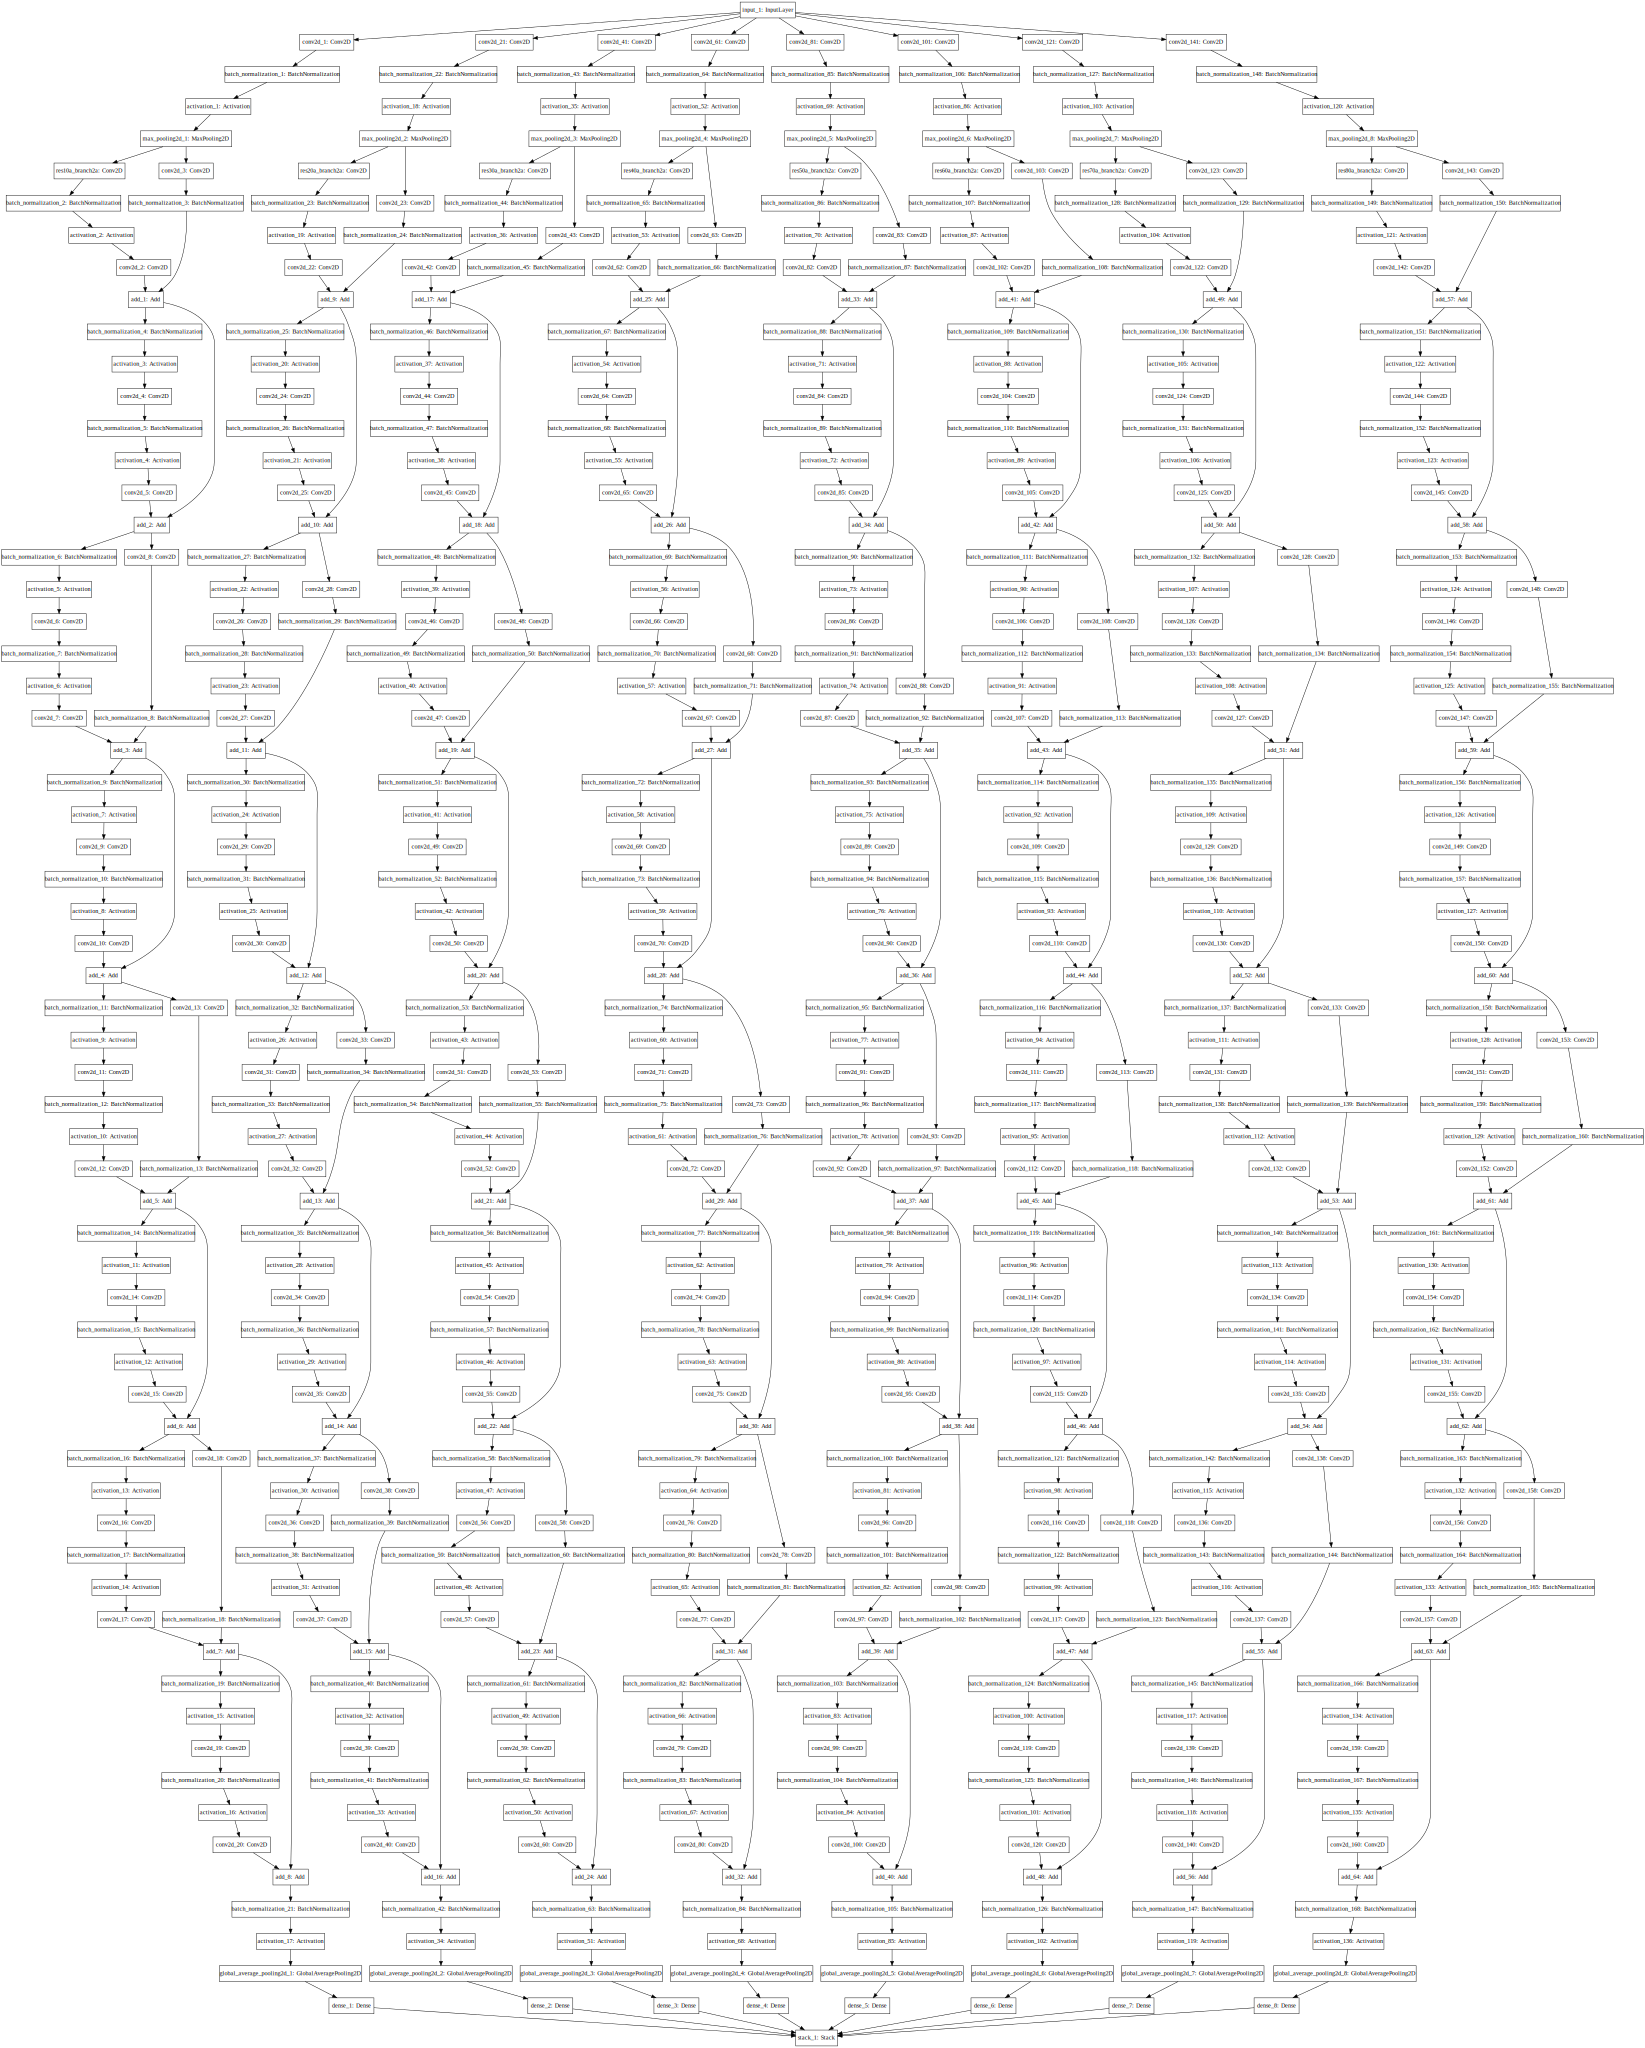

In [3]:
from IPython.display import SVG
from keras.utils.vis_utils import model_to_dot
SVG(model_to_dot(dpe).create(prog='dot', format='svg'))

In [4]:
dpe.summary()

__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            (None, 32, 32, 3)    0                                            
__________________________________________________________________________________________________
conv2d_1 (Conv2D)               (None, 16, 16, 64)   9472        input_1[0][0]                    
__________________________________________________________________________________________________
conv2d_21 (Conv2D)              (None, 16, 16, 64)   9472        input_1[0][0]                    
__________________________________________________________________________________________________
conv2d_41 (Conv2D)              (None, 16, 16, 64)   9472        input_1[0][0]                    
__________________________________________________________________________________________________
conv2d_61 

# Simulate active learning

Below is a simulation of use the ensemble for active learning on the CIFAR10 data.

In [5]:
import keras
from keras.datasets.cifar10 import load_data
import numpy as np
from unittest import mock

(X_train, y_train), (X_test, y_test) = load_data()

X_train = X_train.astype('float32')
X_test = X_test.astype('float32')
X_train = (X_train - X_train.mean(axis=0)) / X_train.std(axis=0)
X_test = (X_test - X_test.mean(axis=0)) / X_train.std(axis=0)

y_train = keras.utils.to_categorical(y_train, 10)
y_train = y_train[:, np.newaxis, :]
y_test = keras.utils.to_categorical(y_test, 10)
y_test = y_test[:, np.newaxis, :]

In [6]:
X_train.shape, y_train.shape

((50000, 32, 32, 3), (50000, 1, 10))

In [7]:
X_test.shape, y_test.shape

((10000, 32, 32, 3), (10000, 1, 10))

In [8]:
from functools import partial
import gc
import time

# the parameters below replicate the "linear-4" experiment from the paper
# with some minor adjustments and shortcuts (e.g. using "h_cat" over "h_ens"
# and not doing random crops on the images).
n_ensemble_members = 8
budget = 16000
n_iterations = 4
max_epochs = 400
patience = 25
# keras param, if non-zero this can blow up the output in the cell below
verbosity = 0

# set up simulation
dpe_builder = partial(DeepProbabalisticEnsemble, (32, 32, 3), 10, n_ensemble_members)
b = budget // n_iterations
n_acquisitions = b
idx = np.random.choice(len(X_train), size=len(X_train), replace=False)
X_labeled, y_labeled = X_train[idx[:b]], y_train[idx[:b]]
X_unlabeled, y_unlabeled = X_train[idx[b:]], y_train[idx[b:]]

datagen = keras.preprocessing.image.ImageDataGenerator(horizontal_flip=True)

In [ ]:
while n_acquisitions < budget:
    print('building ensemble')
    dpe = dpe_builder()
    dpe.compile(loss=ensemble_crossentropy, optimizer='adam', metrics=['accuracy'])
    
    print('training ensemble')
    history = dpe.fit_generator(
        datagen.flow(X_labeled, y_labeled, batch_size=32),
        epochs=400,
        steps_per_epoch=len(X_labeled) // 32,
        validation_data=datagen.flow(X_test, y_test),
        callbacks=[keras.callbacks.ReduceLROnPlateau(patience=25)],
        verbose=verbosity)
    print('trained for %d epochs' % len(history.history['val_loss']))
    print('validation loss:', history.history['val_loss'][-1],
          'validation accuracy:', history.history['val_acc'][-1])

    # aggregate along the individual model predictions
    print('calculating uncertainty of predictions')
    p = dpe.predict(X_unlabeled)
    h_cat = (-p * np.log(p)).sum(axis=(1, 2))  # this is "H_cat" in the paper
    idx_acquisitions = np.argsort(h_cat)[-b:]
    idx_rest = np.argsort(h_cat)[:-b]
    
    print('adding %d examples to training data' % len(idx_acquisitions))
    X_labeled = np.concatenate([X_labeled, X_unlabeled[idx_acquisitions]])
    y_labeled = np.concatenate([y_labeled, y_unlabeled[idx_acquisitions]])
    X_unlabeled = X_unlabeled[idx_rest]
    y_unlabeled = y_unlabeled[idx_rest]
    n_acquisitions += b
    print('%d labeled examples' % len(X_labeled))
    print('%d unlabeled examples' % len(X_unlabeled))

    print('releasing ensemble from GPU memory')
    K.clear_session()
    del dpe
    del history
    gc.collect()

building ensemble
training ensemble
